<a href="https://colab.research.google.com/github/alanfmorato/Churn/blob/main/Desafio_de_Classifica%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gabarito - Desafio de Classificação
## Preveja os usuários com alta chance de deixar seu Streaming
### Overview
Você trabalha em uma plataforma de streaming e a diretoria está preocupada com o alto índice de usuários cancelando as suas assinaturas. Eles acreditam que é possível prever se um usuário tem mais chance de deixar a plataforma antes que isso aconteça, e com base nessa informação tomar ações para reduzir o churn.

Seu objetivo é criar um modelo de classificação capaz de prever se um usuário tem mais chance de cancelar a sua assinatura na plataforma ou não. Para isso, a empresa forneceu uma base de dados em csv contendo dados sobre as contas dos clientes.


### Sobre os dados


Fonte: [DNC](https://drive.google.com/file/d/1Z3z_Inr7WYZKYs5zeW2zi7_1-HNt8jBH/view?usp=sharing)


| Coluna | Descrição | Tipo |
| --- | --- | --- |
| Age | Idade do cliente | Int
| Gender | Gênero do cliente | String
| Time_on_platform | Tempo de uso da plataforma, em horas | Int
| Devices_connected | Quantidade de dispositivos conectados | Int
| Subscription_type | Tipo de conta | String
| Num_streaming_services | Quantidade de serviços de streaming que o cliente possui | Int
| Num_active_profiles | Número de perfis ativos na plataforma | Int
| Avg_rating | Avaliação média dos produtos da plataforma | Float
| Churned | Se o cliente cancelou a conta ou não | Boolean

In [142]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Etapa 01) Análise exploratória dos dados (Data Understanding)

### Importar bibliotecas necessárias

In [143]:
!pip install feature-engine
!pip install scikit-optimize
!pip install scikit-metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [144]:
# análise de dados
import pandas as pd
import numpy as np

# visualização 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# divisão da base de dados
from sklearn.model_selection import train_test_split

# tratamento dos dados categóricos e numéricos
from sklearn.preprocessing import MinMaxScaler

# classificadores
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


# métricas de avaliação de qualidade
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, ConfusionMatrixDisplay

# remoção de aviso de erro para o BayesSearchCV
import warnings
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')

# Acessar o drive
#from google.colab import drive
#drive.mount('/content/drive/')
#%cd /content/drive/My Drive/Colab Notebooks/

## Data Understanding

### Importar base de dados

In [145]:
#Lendo os Dados
clients= pd.read_csv('/content/drive/MyDrive/Datasets/streaming_data.csv')
clients.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49.0,Male,4700.0,3.0,Basic,NaN,3,NaN,0.0,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69.0,Female,6107.0,2.0,Standard,NaN,1,2.14,0.0,fe14b048-770b-4619-8ec6-485b0969ae31
2,44.0,Male,6374.0,3.0,Premium,1.0,1,1.91,1.0,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26.0,Male,NaN,5.0,Basic,NaN,2,NaN,NaN,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
4,18.0,NaN,1948.0,3.0,Basic,NaN,3,3.88,0.0,14879bcb-1977-4ad8-a7f9-6aa9bf7b872f


In [146]:
#Estatísticas Descritivas de todas as colunas

clients.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,66607.0,NaN,NaN,NaN,43.511072,15.043158,18.0,30.0,43.0,57.0,69.0
Gender,63368,2,Male,31796,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Time_on_platform,56464.0,NaN,NaN,NaN,4385.848505,2526.580859,0.0,2196.0,4384.0,6573.0,8759.0
Devices_connected,52696.0,NaN,NaN,NaN,2.99537,1.414072,1.0,2.0,3.0,4.0,5.0
Subscription_type,52663,3,Premium,17625,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Num_streaming_services,9572.0,NaN,NaN,NaN,2.496239,1.1207,1.0,1.0,2.0,4.0,4.0
Num_active_profiles,77884.0,NaN,NaN,NaN,3.002273,1.413235,1.0,2.0,3.0,4.0,5.0
Avg_rating,60614.0,NaN,NaN,NaN,3.002252,1.154963,1.0,1.99,3.01,4.0,5.0
Churned,61148.0,NaN,NaN,NaN,0.243066,0.428938,0.0,0.0,0.0,0.0,1.0
User_id,77884,65481,9c66e5a1-0541-4496-8fbc-ee425ee08b78,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [147]:
#Verificando os tipos de dados
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77884 entries, 0 to 77883
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     66607 non-null  float64
 1   Gender                  63368 non-null  object 
 2   Time_on_platform        56464 non-null  float64
 3   Devices_connected       52696 non-null  float64
 4   Subscription_type       52663 non-null  object 
 5   Num_streaming_services  9572 non-null   float64
 6   Num_active_profiles     77884 non-null  int64  
 7   Avg_rating              60614 non-null  float64
 8   Churned                 61148 non-null  float64
 9   User_id                 77884 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.9+ MB


In [148]:
#Verificando a Quantidade de Nulos
clients.isna().sum()

Age                       11277
Gender                    14516
Time_on_platform          21420
Devices_connected         25188
Subscription_type         25221
Num_streaming_services    68312
Num_active_profiles           0
Avg_rating                17270
Churned                   16736
User_id                       0
dtype: int64

In [149]:
sns.set_palette("Accent")
sns.set_style("darkgrid")

In [150]:
#Agrupando Clientes que deram churn por userid
Churn_UserId = clients.groupby("Churned")['User_id'].count().reset_index()

<Axes: xlabel='Churned', ylabel='User_id'>

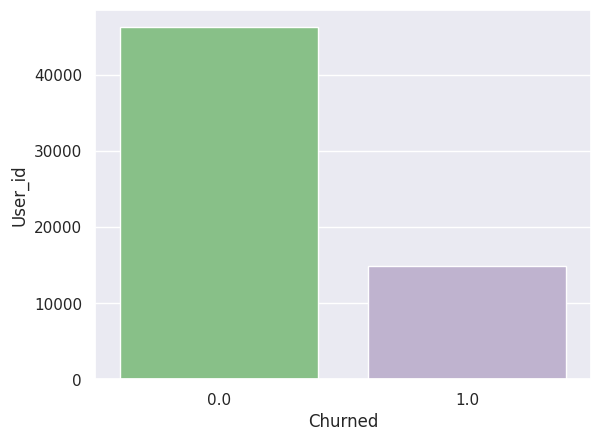

In [151]:
#Plotando quantidade de clientes que deram churn (1) e que não deram churn (0)
sns.barplot(data=Churn_UserId, x = "Churned",y = "User_id")

In [152]:
#Agrupando quantidade de clientes por plano
Churn_Subscription = clients.groupby("Subscription_type")['User_id'].count().reset_index()
Churn_Subscription = pd.DataFrame(Churn_Subscription)
Churn_Subscription

,Subscription_type,User_id
0,Basic,17527
1,Premium,17625
2,Standard,17511


<Axes: xlabel='User_id', ylabel='Subscription_type'>

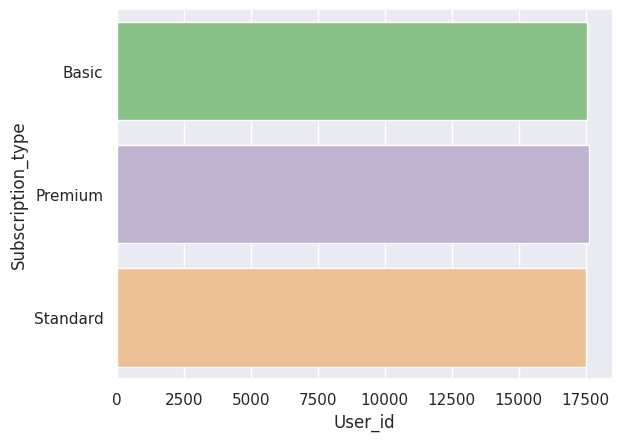

In [153]:
#Plotando quantidade de clientes por plano
sns.barplot(data=Churn_Subscription, x = "User_id",y = "Subscription_type")

In [154]:
#Agrupando quantidade de clientes por genero
Churn_gender = clients.groupby("Gender")['User_id'].count().reset_index()
Churn_gender = pd.DataFrame(Churn_gender)
Churn_gender

,Gender,User_id
0,Female,31572
1,Male,31796


<Axes: xlabel='User_id', ylabel='Gender'>

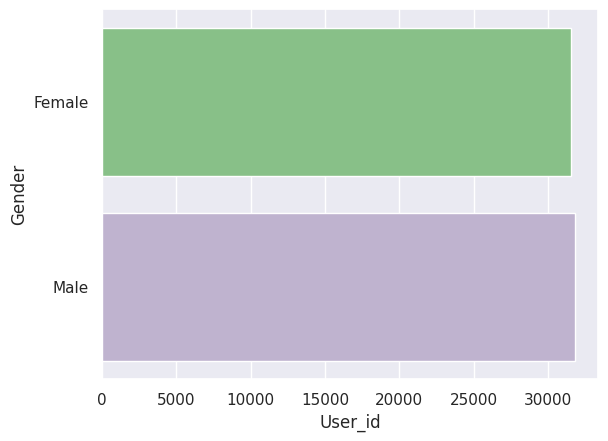

In [155]:
#Plotando quantidade de clientes por genero
sns.barplot(data=Churn_gender, x = "User_id",y = "Gender")

#Etapa 02) Tratamento dos Dados (Data Preparation)

##Data Preparation

In [156]:
#Tratando os valores faltantes
clients['Time_on_platform'] = clients['Time_on_platform'].fillna(0)
clients['Num_streaming_services'] = clients['Num_streaming_services'].fillna(0)
clients['Churned'] = clients['Churned'].fillna(0)
clients['Avg_rating'] = clients['Avg_rating'].fillna(0)
clients['Devices_connected'] = clients['Devices_connected'].fillna(0)


In [157]:
#Dropando valores
clients.dropna(subset=['Gender'], inplace=True)
clients.dropna(subset=['Age'], inplace=True)
clients.dropna(subset=['Subscription_type'], inplace=True)

In [158]:
#Verificando se todos os valores nulos foram eliminados
clients.isna().sum()

Age                       0
Gender                    0
Time_on_platform          0
Devices_connected         0
Subscription_type         0
Num_streaming_services    0
Num_active_profiles       0
Avg_rating                0
Churned                   0
User_id                   0
dtype: int64

In [159]:
#Transformando valores churned 0 e 1 por No e Yes
clients['Churned'] = clients['Churned'].replace(0, 'No')
clients['Churned'] = clients['Churned'].replace(1, 'Yes')

In [160]:
clients.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49.0,Male,4700.0,3.0,Basic,0.0,3,0.00,No,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69.0,Female,6107.0,2.0,Standard,0.0,1,2.14,No,fe14b048-770b-4619-8ec6-485b0969ae31
2,44.0,Male,6374.0,3.0,Premium,1.0,1,1.91,Yes,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26.0,Male,0.0,5.0,Basic,0.0,2,0.00,No,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
5,54.0,Male,3024.0,2.0,Basic,0.0,1,0.00,No,a1df3a13-9255-4d00-8a9d-20565fefaab9


In [161]:
#Transformando valores floats em valores inteiros
clients['Age'] = clients['Age'].astype(int)
clients['Time_on_platform'] = clients['Time_on_platform'].astype(int)
clients['Num_streaming_services'] = clients['Num_streaming_services'].astype(int)

#Etapa 03) Modelagem dos Dados - Regressão Logística

##Regressão Logística

In [162]:
clients.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49,Male,4700,3.0,Basic,0,3,0.00,No,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69,Female,6107,2.0,Standard,0,1,2.14,No,fe14b048-770b-4619-8ec6-485b0969ae31
2,44,Male,6374,3.0,Premium,1,1,1.91,Yes,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26,Male,0,5.0,Basic,0,2,0.00,No,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
5,54,Male,3024,2.0,Basic,0,1,0.00,No,a1df3a13-9255-4d00-8a9d-20565fefaab9


In [163]:
#Definindo variáveis, não queremos o user_id e o churned pois o churned será utilizado na variável y e o user id não é parâmetro
X = clients.drop(columns=['User_id', 'Churned'], axis = 1)

In [164]:
#Definindo variáveis
y = clients[['Churned']]

In [165]:
#Fitando modelo
le = LabelEncoder()
le.fit(y.Churned)
y.Churned = le.transform(y.Churned)
X = pd.get_dummies(X)

<ipython-input-165-797273e92d7d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.Churned = le.transform(y.Churned)


In [167]:
#Feature engineering
mm = MinMaxScaler()
X = pd.DataFrame(mm.fit_transform(X))

In [168]:
#Separando a base de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [169]:
#Modelando
model = LogisticRegression()

In [170]:
#Fitando o modelo
lr = model.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [171]:
lr.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [172]:
X_test.assign(clients=y_test).assign(label = lr.predict(X_test))

,0,1,2,3,4,5,6,7,8,9,10,clients,label
6140,0.215686,0.000000,0.6,0.00,0.25,0.300,1.0,0.0,1.0,0.0,0.0,NaN,0
33455,0.352941,0.789360,1.0,0.00,1.00,0.450,1.0,0.0,0.0,1.0,0.0,NaN,0
17940,0.568627,0.000000,1.0,0.00,0.00,0.718,0.0,1.0,1.0,0.0,0.0,NaN,0
8040,0.411765,0.579290,0.0,0.00,0.75,0.874,0.0,1.0,0.0,0.0,1.0,NaN,0
30450,0.823529,0.000000,0.2,0.50,0.00,0.266,1.0,0.0,0.0,0.0,1.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28671,0.196078,0.965407,0.0,0.00,1.00,0.260,1.0,0.0,1.0,0.0,0.0,NaN,0
17894,0.686275,0.828748,0.0,0.00,0.75,0.000,0.0,1.0,0.0,0.0,1.0,NaN,0
30866,0.588235,0.178445,0.0,0.00,0.00,0.326,1.0,0.0,1.0,0.0,0.0,NaN,0
30272,0.019608,0.060852,0.4,0.00,0.25,0.462,1.0,0.0,0.0,1.0,0.0,NaN,0


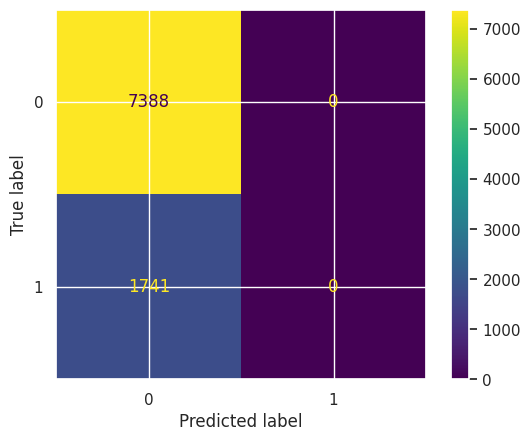

In [173]:
#Matriz confusão
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test, values_format = "d")

In [174]:
#Métricas
print(f"Acurácia (Treino): {accuracy_score(y_train, lr.predict(X_train))}")
print(f"Acurácia (Teste): {accuracy_score(y_test, lr.predict(X_test))}")
print("====================================")
print(f"Acurácia Balanceada (Treino): {balanced_accuracy_score(y_train, lr.predict(X_train))}")
print(f"Acurácia Balanceada (Teste): {balanced_accuracy_score(y_test, lr.predict(X_test))}")
print("====================================")
print(f"Precision (Treino): {precision_score(y_train, lr.predict(X_train))}")
print(f"Precision (Teste): {precision_score(y_test, lr.predict(X_test))}")
print("====================================")
print(f"Recall (Treino): {recall_score(y_train, lr.predict(X_train))}")
print(f"Recall (Teste): {recall_score(y_test, lr.predict(X_test))}")
print("====================================")
print(f"F1-Score (Treino): {f1_score(y_train, lr.predict(X_train))}")
print(f"F1-Score (Teste): {f1_score(y_test, lr.predict(X_test))}")
print("====================================")
print(f"ROCAUC (Treino): {roc_auc_score(y_train, lr.predict_proba(X_train)[:,1])}")
print(f"ROCAUC (Teste): {roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])}")

Acurácia (Treino): 0.8059227342437741
Acurácia (Teste): 0.8092890787599957
Acurácia Balanceada (Treino): 0.5
Acurácia Balanceada (Teste): 0.5
Precision (Treino): 0.0
Precision (Teste): 0.0
Recall (Treino): 0.0
Recall (Teste): 0.0
F1-Score (Treino): 0.0
F1-Score (Teste): 0.0
ROCAUC (Treino): 0.5140188597706546
ROCAUC (Teste): 0.5069992570655738


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Etapa 04) Modelagem dos Dados - Random Forest

##Random Forest


In [175]:
from sklearn.ensemble import RandomForestClassifier

rf =  RandomForestClassifier()

In [176]:
rf.fit(X_train, y_train)

<ipython-input-176-168a6fc83696>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RandomForestClassifier()

In [177]:
rf.predict(X_test)

array([0, 0, 0, ..., 0, 1, 0])

In [178]:
X_test.assign(churn = y_test).assign(label = rf.predict(X_test))

,0,1,2,3,4,5,6,7,8,9,10,churn,label
6140,0.215686,0.000000,0.6,0.00,0.25,0.300,1.0,0.0,1.0,0.0,0.0,NaN,0
33455,0.352941,0.789360,1.0,0.00,1.00,0.450,1.0,0.0,0.0,1.0,0.0,NaN,0
17940,0.568627,0.000000,1.0,0.00,0.00,0.718,0.0,1.0,1.0,0.0,0.0,NaN,0
8040,0.411765,0.579290,0.0,0.00,0.75,0.874,0.0,1.0,0.0,0.0,1.0,NaN,0
30450,0.823529,0.000000,0.2,0.50,0.00,0.266,1.0,0.0,0.0,0.0,1.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28671,0.196078,0.965407,0.0,0.00,1.00,0.260,1.0,0.0,1.0,0.0,0.0,NaN,0
17894,0.686275,0.828748,0.0,0.00,0.75,0.000,0.0,1.0,0.0,0.0,1.0,NaN,0
30866,0.588235,0.178445,0.0,0.00,0.00,0.326,1.0,0.0,1.0,0.0,0.0,NaN,0
30272,0.019608,0.060852,0.4,0.00,0.25,0.462,1.0,0.0,0.0,1.0,0.0,NaN,1


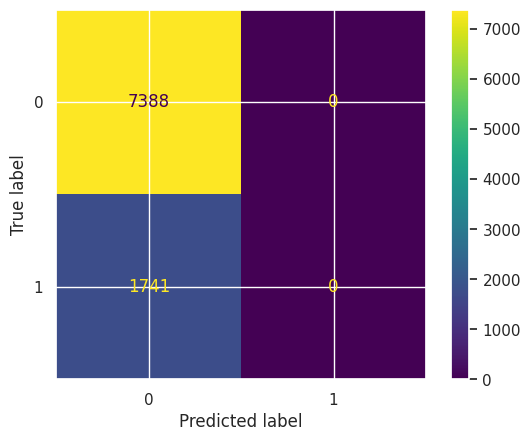

In [179]:
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test, values_format = "d")

In [180]:

print(f"Acurácia (Treino): {accuracy_score(y_train, rf.predict(X_train))}")
print(f"Acurácia (Teste): {accuracy_score(y_test, rf.predict(X_test))}")
print("====================================")
print(f"Acurácia Balanceada (Treino): {balanced_accuracy_score(y_train, rf.predict(X_train))}")
print(f"Acurácia Balanceada (Teste): {balanced_accuracy_score(y_test, rf.predict(X_test))}")
print("====================================")
print(f"Precision (Treino): {precision_score(y_train, rf.predict(X_train))}")
print(f"Precision (Teste): {precision_score(y_test, rf.predict(X_test))}")
print("====================================")
print(f"Recall (Treino): {recall_score(y_train, rf.predict(X_train))}")
print(f"Recall (Teste): {recall_score(y_test, rf.predict(X_test))}")
print("====================================")
print(f"F1-Score (Treino): {f1_score(y_train, rf.predict(X_train))}")
print(f"F1-Score (Teste): {f1_score(y_test, rf.predict(X_test))}")
print("====================================")
print(f"ROCAUC (Treino): {roc_auc_score(y_train, rf.predict_proba(X_train)[:,1])}")
print(f"ROCAUC (Teste): {roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])}")

Acurácia (Treino): 0.9986489447162784
Acurácia (Teste): 0.8444517471793187
Acurácia Balanceada (Treino): 0.9972334771989806
Acurácia Balanceada (Teste): 0.6172129883223396
Precision (Treino): 0.9981124952812382
Precision (Teste): 0.7923497267759563
Recall (Treino): 0.9949200376293509
Recall (Teste): 0.2498564043653073
F1-Score (Treino): 0.9965137096014323
F1-Score (Teste): 0.37991266375545846
ROCAUC (Treino): 0.9999782622344301
ROCAUC (Teste): 0.690651854210703


#Etapa 05) Modelagem dos Dados - Tunning

##Tunning

In [181]:
# Importamos GridSearchCV
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'n_estimators': [100, 300, 500]}

grid_search = GridSearchCV(rf, parameters, scoring='accuracy', cv=5, n_jobs=-1)

In [182]:
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [100, 300, 500]},
             scoring='accuracy')

In [183]:
dict = grid_search.best_estimator_.get_params()

In [184]:
from sklearn.ensemble import RandomForestClassifier

rf_tunned =  RandomForestClassifier(bootstrap = True, ccp_alpha = 0.0,
                                     class_weight = None, criterion= 'gini',
                                     max_depth = 10, max_features= 'auto',
                                     max_leaf_nodes = None,
                                     max_samples = None,
                                     min_impurity_decrease = 0.0,
                                     min_samples_leaf = 1,
                                     min_samples_split = 2,
                                     min_weight_fraction_leaf = 0.0,
                                     n_estimators = 500, n_jobs = None,
                                     oob_score = False, random_state = None,
                                     verbose = 0, warm_start = False)

In [185]:
rf_tunned.fit(X_train, y_train)

<ipython-input-185-23d38da6abb7>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_tunned.fit(X_train, y_train)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_depth=10, max_features='auto', n_estimators=500)

In [186]:
rf_tunned.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [187]:
X_test.assign(churn = y_test).assign(label = rf_tunned.predict(X_test))

,0,1,2,3,4,5,6,7,8,9,10,churn,label
6140,0.215686,0.000000,0.6,0.00,0.25,0.300,1.0,0.0,1.0,0.0,0.0,NaN,0
33455,0.352941,0.789360,1.0,0.00,1.00,0.450,1.0,0.0,0.0,1.0,0.0,NaN,0
17940,0.568627,0.000000,1.0,0.00,0.00,0.718,0.0,1.0,1.0,0.0,0.0,NaN,0
8040,0.411765,0.579290,0.0,0.00,0.75,0.874,0.0,1.0,0.0,0.0,1.0,NaN,0
30450,0.823529,0.000000,0.2,0.50,0.00,0.266,1.0,0.0,0.0,0.0,1.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28671,0.196078,0.965407,0.0,0.00,1.00,0.260,1.0,0.0,1.0,0.0,0.0,NaN,0
17894,0.686275,0.828748,0.0,0.00,0.75,0.000,0.0,1.0,0.0,0.0,1.0,NaN,0
30866,0.588235,0.178445,0.0,0.00,0.00,0.326,1.0,0.0,1.0,0.0,0.0,NaN,0
30272,0.019608,0.060852,0.4,0.00,0.25,0.462,1.0,0.0,0.0,1.0,0.0,NaN,0


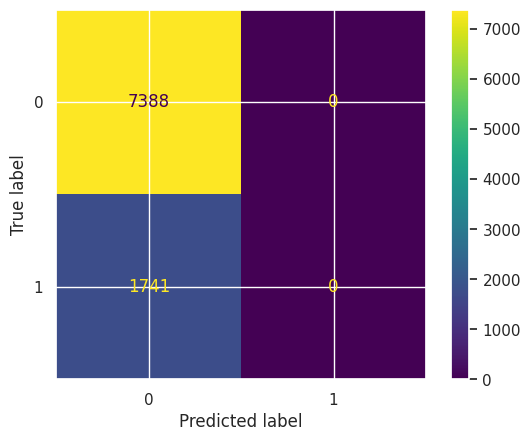

In [188]:
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test, values_format = "d")

In [189]:
print(f"Acurácia (Treino): {accuracy_score(y_train, rf_tunned.predict(X_train))}")
print(f"Acurácia (Teste): {accuracy_score(y_test, rf_tunned.predict(X_test))}")
print("====================================")
print(f"Acurácia Balanceada (Treino): {balanced_accuracy_score(y_train, rf_tunned.predict(X_train))}")
print(f"Acurácia Balanceada (Teste): {balanced_accuracy_score(y_test, rf_tunned.predict(X_test))}")
print("====================================")
print(f"Precision (Treino): {precision_score(y_train, rf_tunned.predict(X_train))}")
print(f"Precision (Teste): {precision_score(y_test, rf_tunned.predict(X_test))}")
print("====================================")
print(f"Recall (Treino): {recall_score(y_train, rf_tunned.predict(X_train))}")
print(f"Recall (Teste): {recall_score(y_test, rf_tunned.predict(X_test))}")
print("====================================")
print(f"F1-Score (Treino): {f1_score(y_train, rf_tunned.predict(X_train))}")
print(f"F1-Score (Teste): {f1_score(y_test, rf_tunned.predict(X_test))}")
print("====================================")
print(f"ROCAUC (Treino): {roc_auc_score(y_train, rf_tunned.predict_proba(X_train)[:,1])}")
print(f"ROCAUC (Teste): {roc_auc_score(y_test, rf_tunned.predict_proba(X_test)[:,1])}")

Acurácia (Treino): 0.8069451544584825
Acurácia (Teste): 0.8092890787599957
Acurácia Balanceada (Treino): 0.5026340545625588
Acurácia Balanceada (Teste): 0.5
Precision (Treino): 1.0


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision (Teste): 0.0
Recall (Treino): 0.005268109125117592
Recall (Teste): 0.0
F1-Score (Treino): 0.010481003181733109
F1-Score (Teste): 0.0
ROCAUC (Treino): 0.9240035099245474
ROCAUC (Teste): 0.5994881402600488
